# Model training, testing and selection

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, KFold


In [44]:
data = pd.read_csv('../data/cleaned_data.csv')

In [45]:
X = data.drop('price', axis=1)
y = data['price']

X_work, X_test, y_work, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_work, y_work, test_size=0.2 ,random_state=42)

In [46]:
def safe_mape(y_true, y_pred, epsilon=1e-10):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_idx = np.abs(y_true) > epsilon
    if not np.any(non_zero_idx):
        return np.nan  # or some fallback value
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100


In [47]:
def evaluate_model(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        results[name] = {
            'R2': r2_score(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': root_mean_squared_error(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'MAPE': safe_mape(y_test, y_pred)
        }
    return pd.DataFrame(results).T.sort_values(by='R2', ascending=False)


In [48]:

def visualize_results(results_df):
    """
    Visualizes evaluation metrics of models using individual bar plots per metric.
    """
    # Set plot style
    sns.set(style="whitegrid")

    # Reshape results for plotting
    results_melted = results_df.reset_index().melt(id_vars='index', 
                                                   var_name='Metric', 
                                                   value_name='Value')
    results_melted.rename(columns={'index': 'Model'}, inplace=True)

    # Plot each metric separately
    unique_metrics = results_melted['Metric'].unique()
    for metric in unique_metrics:
        metric_data = results_melted[results_melted['Metric'] == metric]

        plt.figure(figsize=(10, 5))
        sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')
        plt.title(f'{metric} by Model')
        plt.ylabel(metric)
        plt.xlabel('Model')
        plt.xticks(rotation=45)

        # Annotate values on bars
        for i, row in metric_data.iterrows():
            plt.text(i % len(metric_data['Model'].unique()), row['Value'], 
                     f"{row['Value']:.2f}", ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()


In [49]:
def plot_predictions(models, X_test, y_test):
    """
    Generate scatter plots of actual vs. predicted values for each model.
    """
    n_models = len(models)
    n_cols = 2
    n_rows = int(np.ceil(n_models / n_cols))

    plt.figure(figsize=(6 * n_cols, 4.5 * n_rows))
    sns.set(style="whitegrid")

    for idx, (name, model) in enumerate(models.items(), 1):
        y_pred = model.predict(X_test)

        plt.subplot(n_rows, n_cols, idx)
        sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.6, s=40)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # perfect fit line
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{name} - Actual vs Predicted")
        plt.tight_layout()

    plt.suptitle("Scatter Plots: Actual vs Predicted", fontsize=16, y=1.02)
    plt.show()

## 1. Round 1 - Initial model comparisson

In [50]:
LR = LinearRegression()
DT = DecisionTreeRegressor(random_state=42)
RF = RandomForestRegressor(random_state=42)
SVR = SVR()
KNN = KNeighborsRegressor()
XGB = xgb.XGBRegressor(random_state=42)

LR.fit(X_train, y_train)
DT.fit(X_train, y_train)    
RF.fit(X_train, y_train)
SVR.fit(X_train, y_train)
KNN.fit(X_train, y_train)
XGB.fit(X_train, y_train)

models = {
    'Linear Regression': LR,
    'Decision Tree': DT,
    'Random Forest': RF,
    'Support Vector Regression': SVR,
    'K-Nearest Neighbors': KNN,
    'XGBoost': XGB
}

results = evaluate_model(models, X_val, y_val)
results

,R2,MSE,RMSE,MAE,MAPE
K-Nearest Neighbors,0.625832,4.001669e+10,200041.715639,108959.099497,21.361481
Linear Regression,0.614387,4.124066e+10,203077.963997,127452.643387,25.045198
Random Forest,0.613580,4.132704e+10,203290.522731,109639.249019,21.087572
XGBoost,0.586620,4.421030e+10,210262.452032,108765.318604,20.567056
Decision Tree,0.283222,7.665832e+10,276872.395487,158335.242512,29.766842
Support Vector Regression,-0.055506,1.128847e+11,335983.191478,221700.617624,49.982913


C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


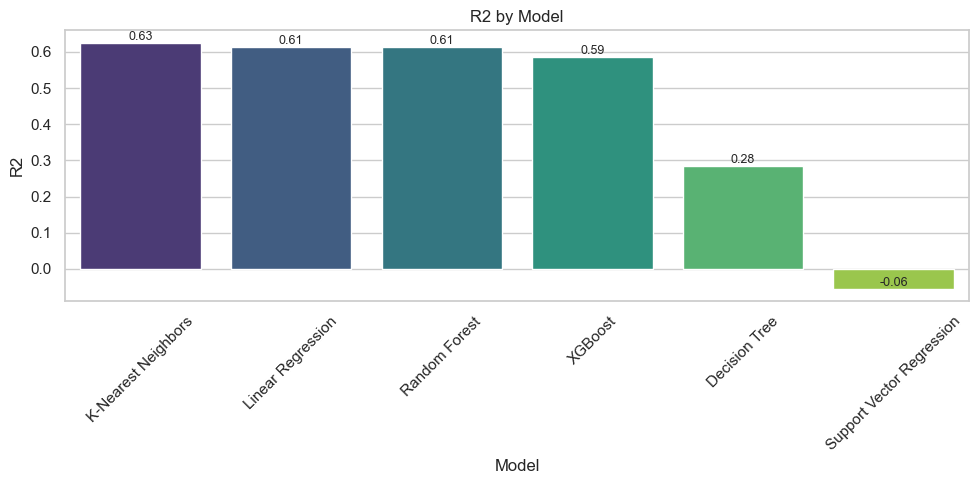

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


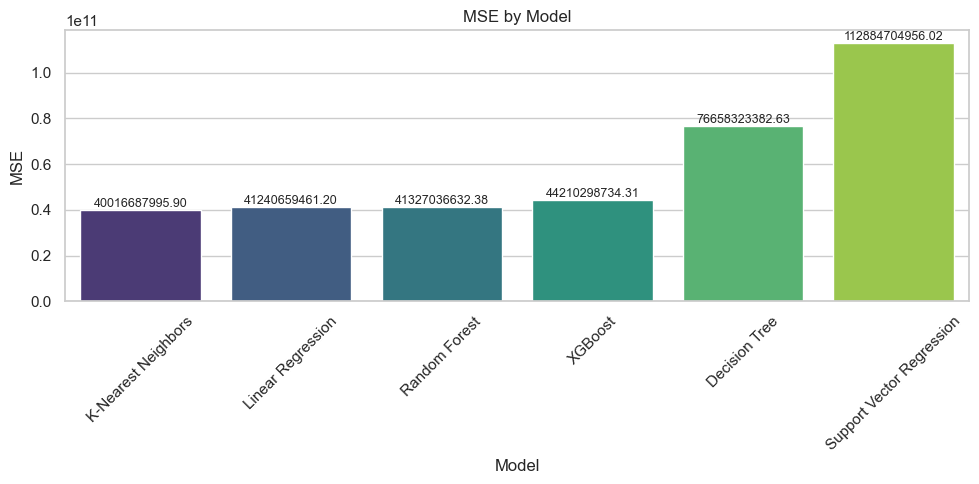

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


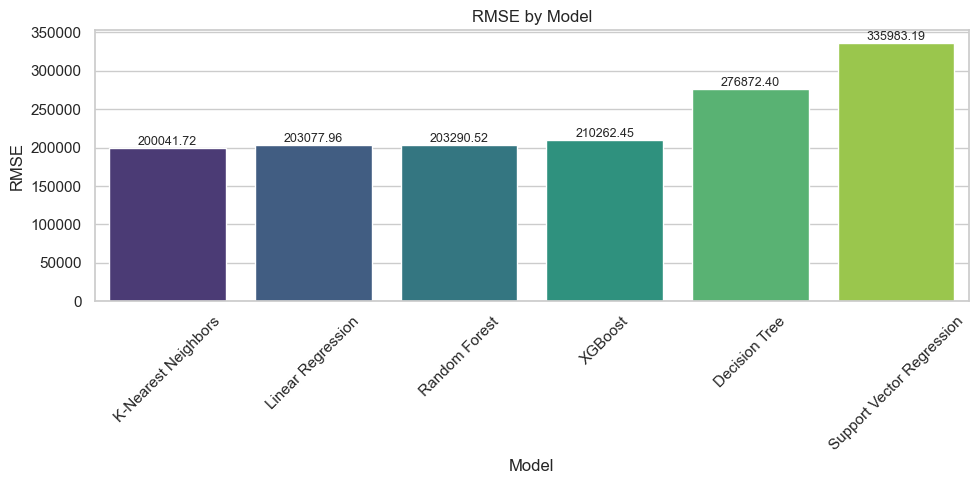

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


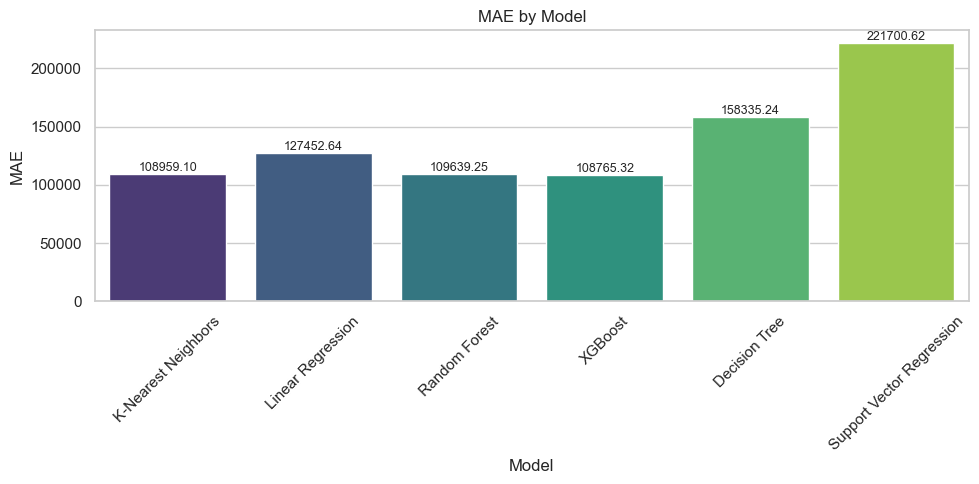

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


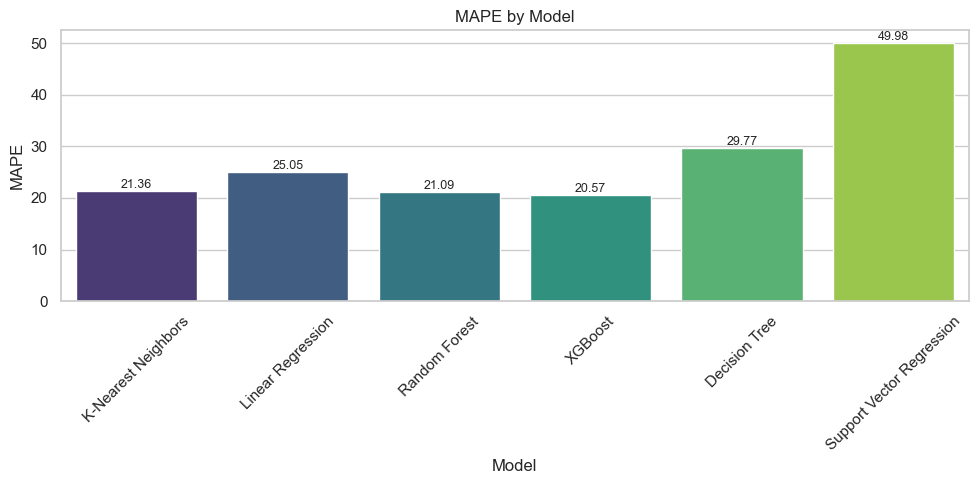

In [51]:
visualize_results(results)

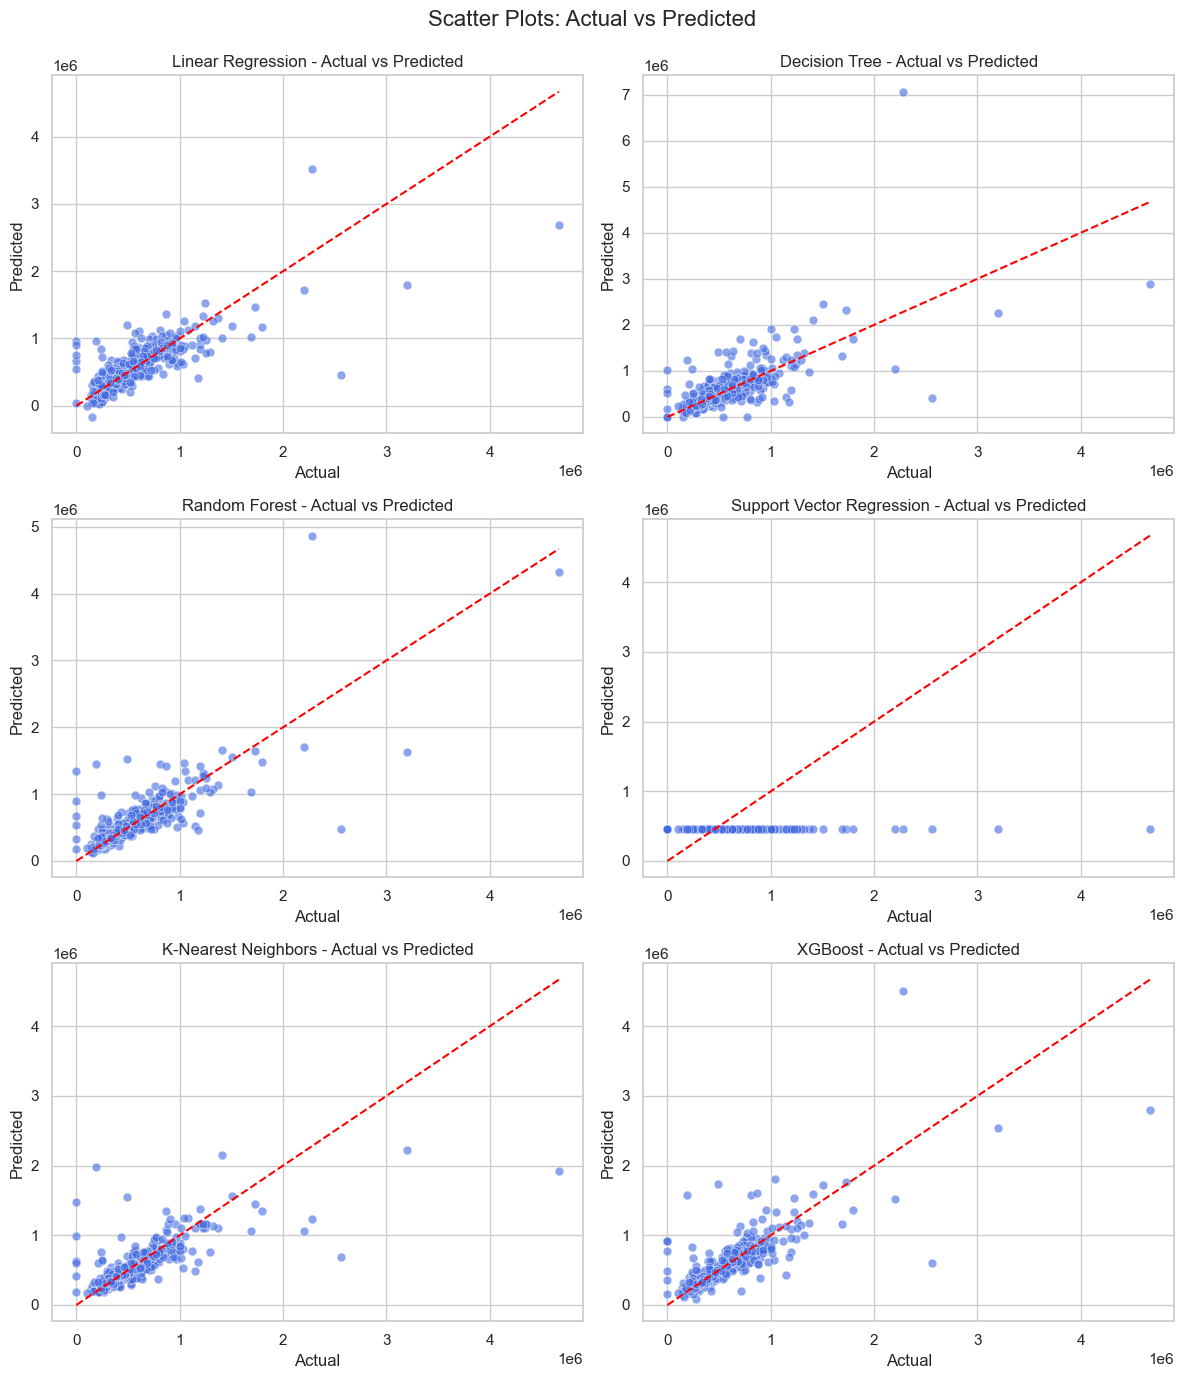

In [52]:
plot_predictions(models, X_test, y_test)

## 2. Round 2 - Hyperparameter optimization

In [53]:
def run_randomized_search(models, X_train, y_train, cv_splitter, n_iter=30):
    """
    Run RandomizedSearchCV on provided models and param grids,
    return best estimators in a dict.
    
    Args:
        models (dict): {model_name: (estimator, param_grid)}
        X_train, y_train: training data
        cv_splitter: cross-validation splitter (e.g. KFold object)
        n_iter (int): number of iterations for RandomizedSearchCV
    
    Returns:
        dict: best estimators keyed by model name
    """
    best_estimators = {}

    for name, (model, params) in models.items():
        print(f"Running RandomizedSearchCV for {name}...")
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=n_iter,
            scoring='neg_mean_squared_error',
            cv=cv_splitter,
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        search.fit(X_train, y_train)
        best_estimators[name] = search.best_estimator_

        print(f"Best score (neg MSE) for {name}: {search.best_score_:.4f}")
        print(f"Best estimator for {name}:\n{search.best_estimator_}\n")

    return best_estimators

In [54]:
from sklearn.model_selection import KFold

# Your parameter grids here (same as before)
rf_params = {
    'n_estimators': np.arange(50, 300, 25),
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

dt_params = {
    'max_depth': [None] + list(np.arange(3, 20)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

xgb_params = {
    'n_estimators': np.arange(50, 300, 25),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': np.arange(3, 15),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

knn_params = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

lr_params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

models = {
    'RandomForest': (RandomForestRegressor(), rf_params),
    'DecisionTree': (DecisionTreeRegressor(), dt_params),
    'XGBoost': (xgb.XGBRegressor(verbosity=0), xgb_params),
    'KNN': (KNeighborsRegressor(), knn_params),
    'LinearRegression': (LinearRegression(), lr_params)
}

kfold = KFold(n_splits=7, shuffle=True, random_state=42)

# Run RandomizedSearchCV and get best models
best_estimators = run_randomized_search(models, X_train, y_train, kfold, n_iter=60)

# Now best_estimators is a dict you can use for further comparison or evaluation

Running RandomizedSearchCV for RandomForest...
Fitting 7 folds for each of 60 candidates, totalling 420 fits


C:\data\edu\ai\data-science\projects\house-price-prediction-ML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
147 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "C:\data\edu\ai\data-science\projects\house-price-prediction-ML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\data\edu\ai\data-science\projects\house-price-prediction-ML\.venv\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
 

Best score (neg MSE) for RandomForest: -54220570357.3391
Best estimator for RandomForest:
RandomForestRegressor(max_depth=np.int64(14), max_features='log2',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=np.int64(175))

Running RandomizedSearchCV for DecisionTree...
Fitting 7 folds for each of 60 candidates, totalling 420 fits


C:\data\edu\ai\data-science\projects\house-price-prediction-ML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
112 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
67 fits failed with the following error:
Traceback (most recent call last):
  File "C:\data\edu\ai\data-science\projects\house-price-prediction-ML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\data\edu\ai\data-science\projects\house-price-prediction-ML\.venv\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  

Best score (neg MSE) for DecisionTree: -65745874596.4054
Best estimator for DecisionTree:
DecisionTreeRegressor(max_depth=np.int64(8), max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10)

Running RandomizedSearchCV for XGBoost...
Fitting 7 folds for each of 60 candidates, totalling 420 fits
Best score (neg MSE) for XGBoost: -49843680771.5277
Best estimator for XGBoost:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=np.int64(5),
             max_leaves=None, min_child_wei

C:\data\edu\ai\data-science\projects\house-price-prediction-ML\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=60. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [55]:
evaluate_model(best_estimators, X_val, y_val)

,R2,MSE,RMSE,MAE,MAPE
RandomForest,0.629907,3.958086e+10,198949.378574,112012.272481,22.637834
XGBoost,0.623876,4.022591e+10,200563.968973,104566.708293,20.258500
LinearRegression,0.614387,4.124066e+10,203077.963997,127452.643387,25.045198
KNN,0.613799,4.130357e+10,203232.798812,107345.848963,21.138948
DecisionTree,0.386423,6.562108e+10,256166.120499,141104.730734,27.979032


C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


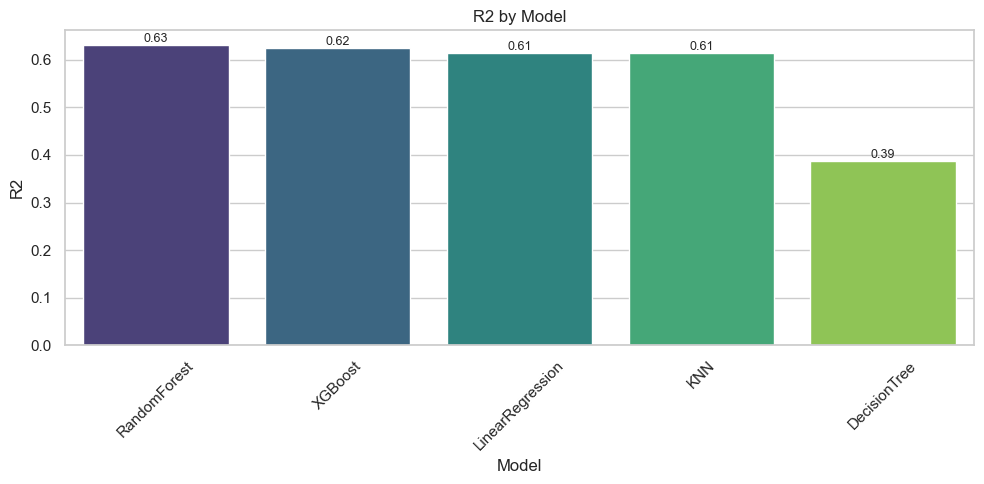

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


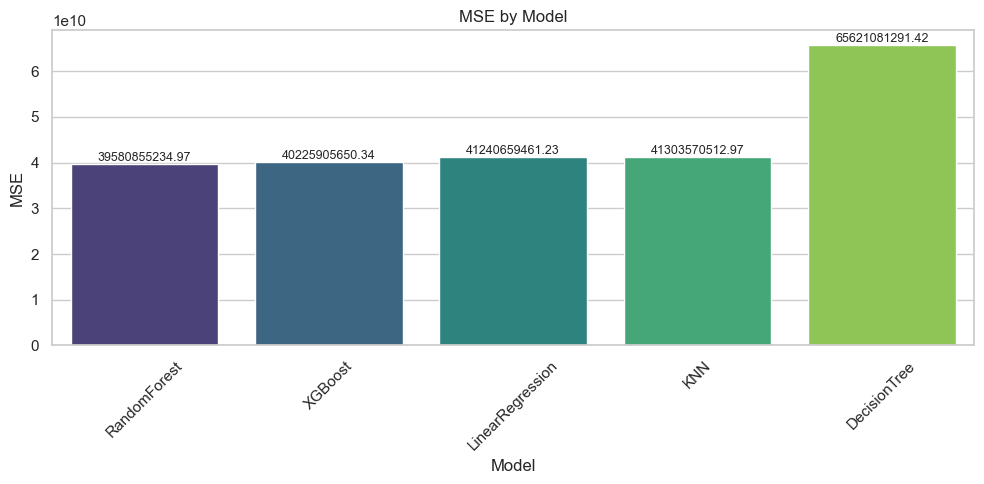

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


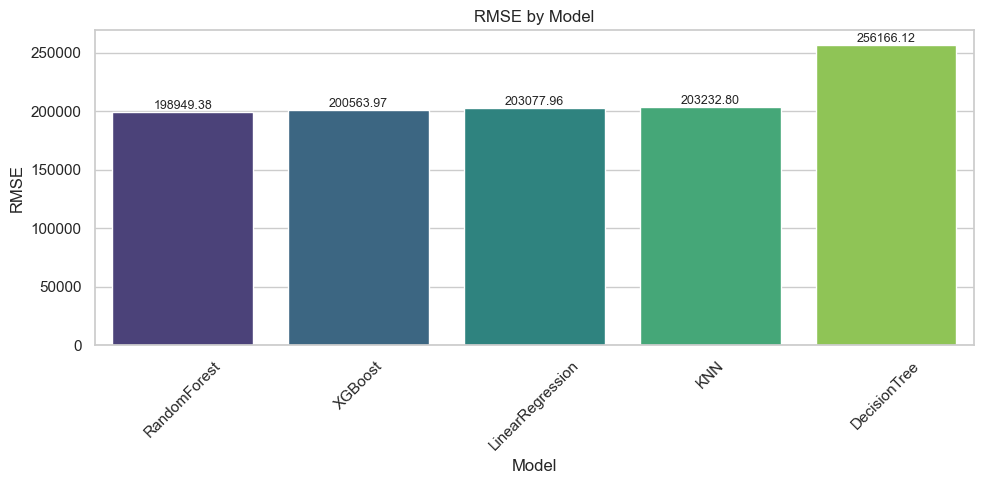

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


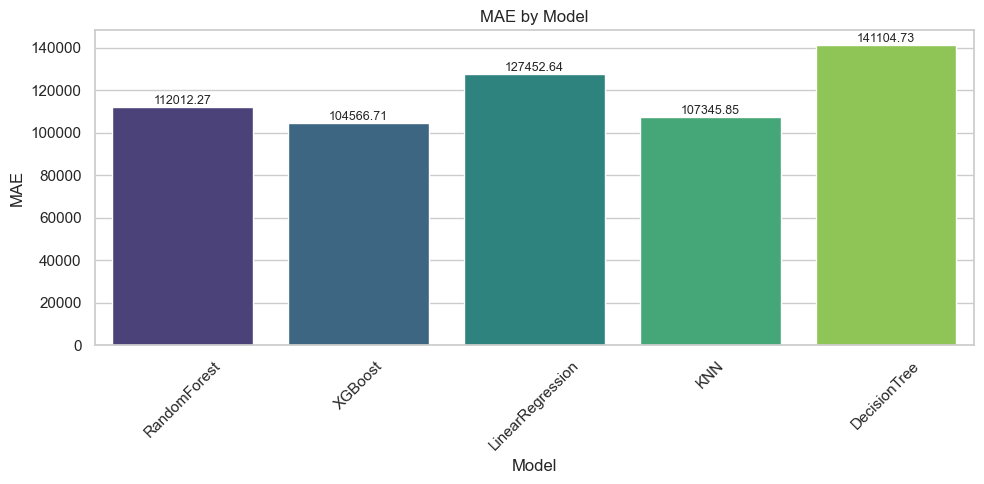

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


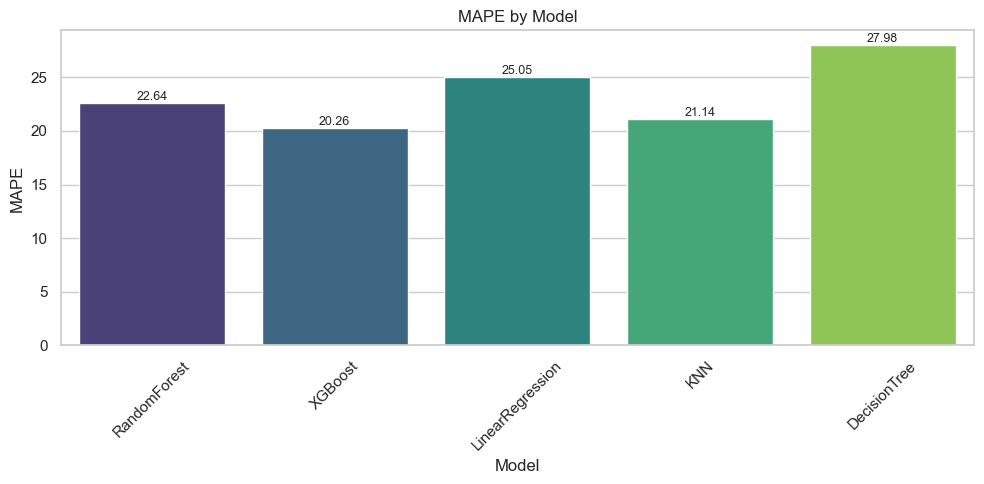

In [56]:
visualize_results(evaluate_model(best_estimators, X_val, y_val))

## 3. Round 3 - 

In [59]:
# Creating a stacking model - meta learner on top of the previous model outputs/inputs
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

# Your best estimators, with hyperparameters filled in:
estimators = [
    ('rf', RandomForestRegressor(
        n_estimators=50,
        max_features='sqrt',
        min_samples_split=5,
        random_state=42)),
    ('dt', DecisionTreeRegressor(
        max_depth=6,
        max_features='log2',
        min_samples_leaf=2,
        min_samples_split=10,
        random_state=42)),
    ('xgb', xgb.XGBRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        subsample=1.0,
        colsample_bytree=0.6,
        gamma=0,
        reg_alpha=0,
        reg_lambda=1,
        verbosity=0,
        random_state=42)),
    ('knn', KNeighborsRegressor(
        n_neighbors=9,
        weights='distance',
        p=1)),
    ('lr', LinearRegression(
        fit_intercept=False))
]

# Use RidgeCV as the meta-learner to add a bit of regularization:
meta_learner = RidgeCV(alphas=[0.1, 1.0, 10.0])

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=kfold,
    n_jobs=-1,
    passthrough=False  # or True if you want base features too
)

# Fit on training data
stack.fit(X_train, y_train)

# Quick cross-validated check
scores = cross_val_score(stack, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print("Stacking CV Neg MSE:", scores.mean(), "±", scores.std())

# Finally, evaluate on your hold-outset:
stack_test_mse = mean_squared_error(y_test, stack.predict(X_test))
print("Test MSE:", stack_test_mse)

Stacking CV Neg MSE: -51177043611.04719 ± 25916165165.091015
Test MSE: 55934956132.22543


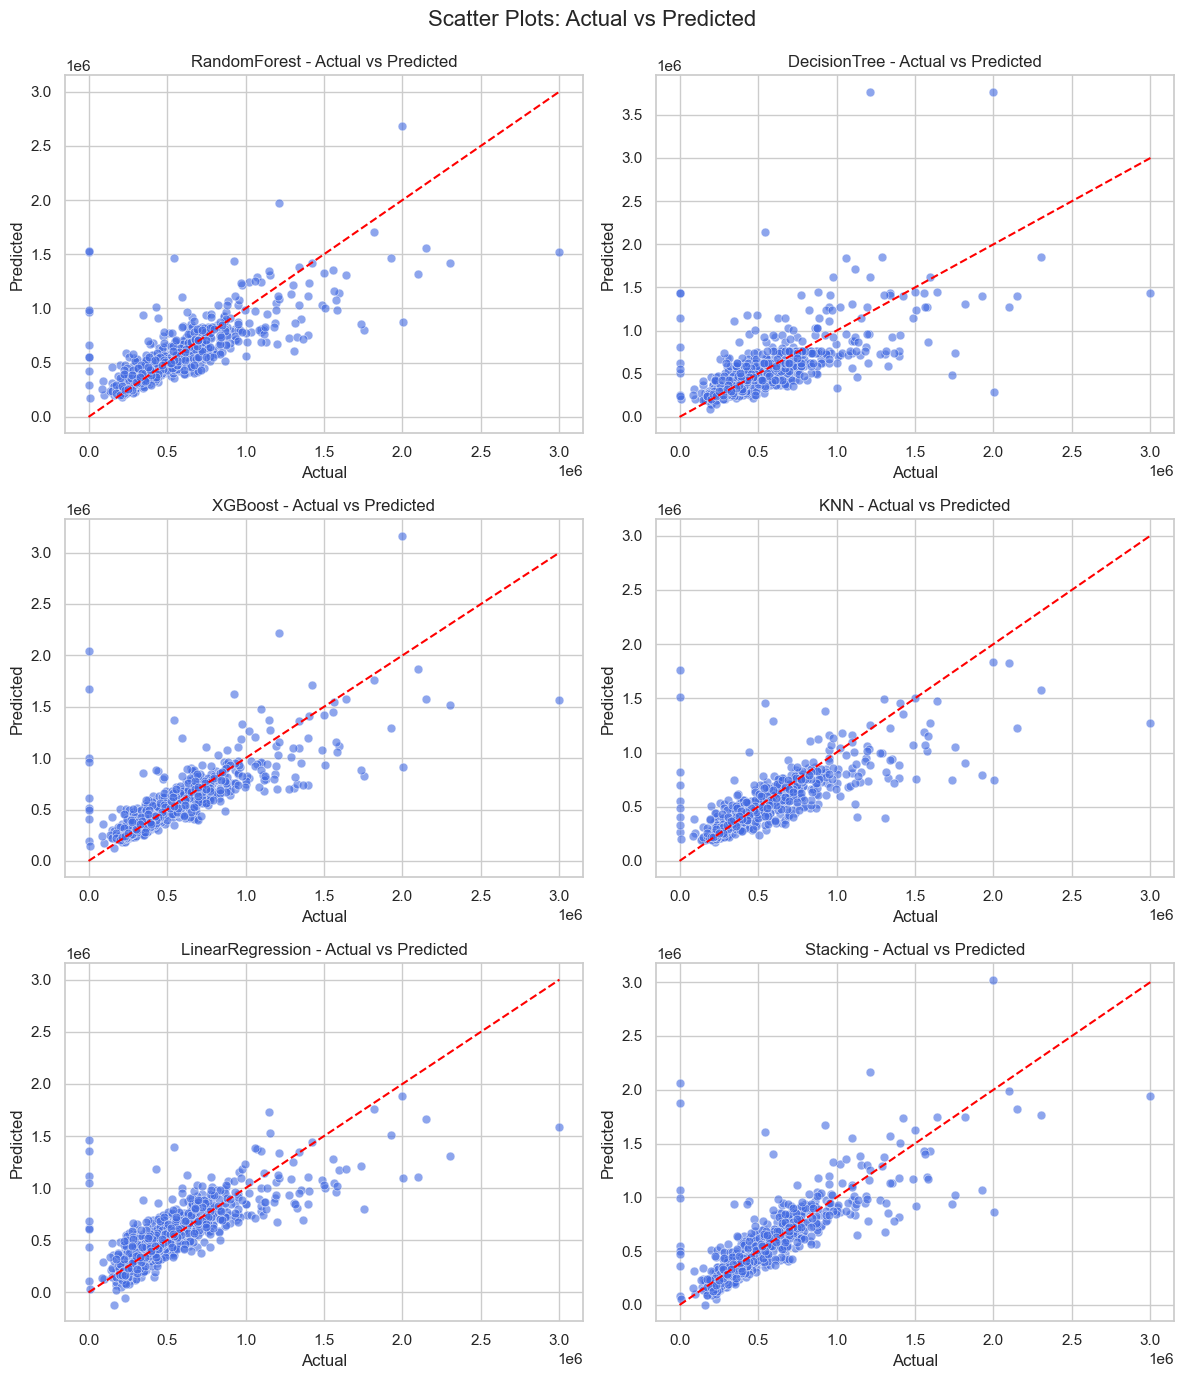

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


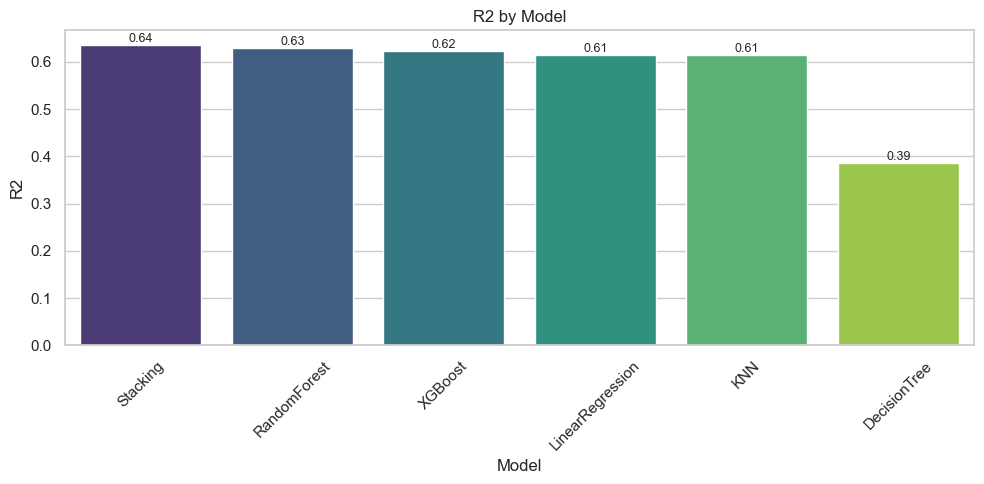

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


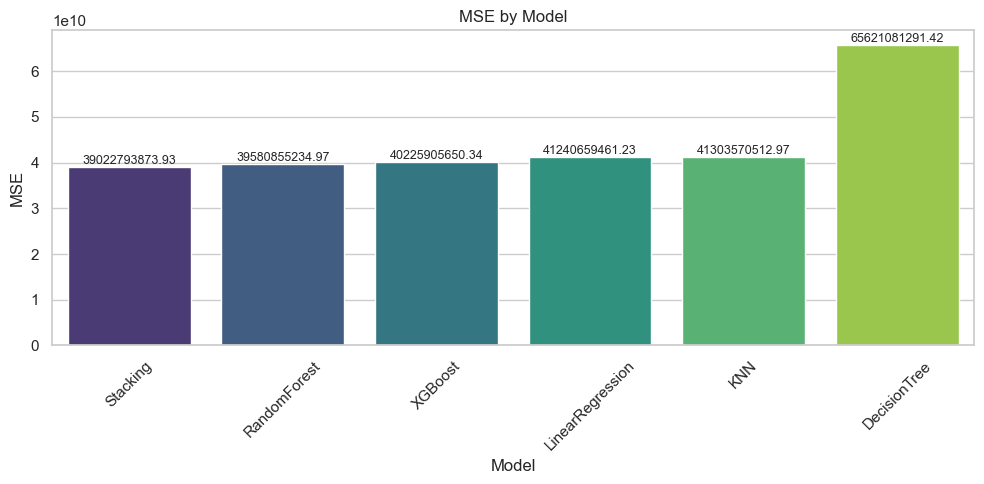

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


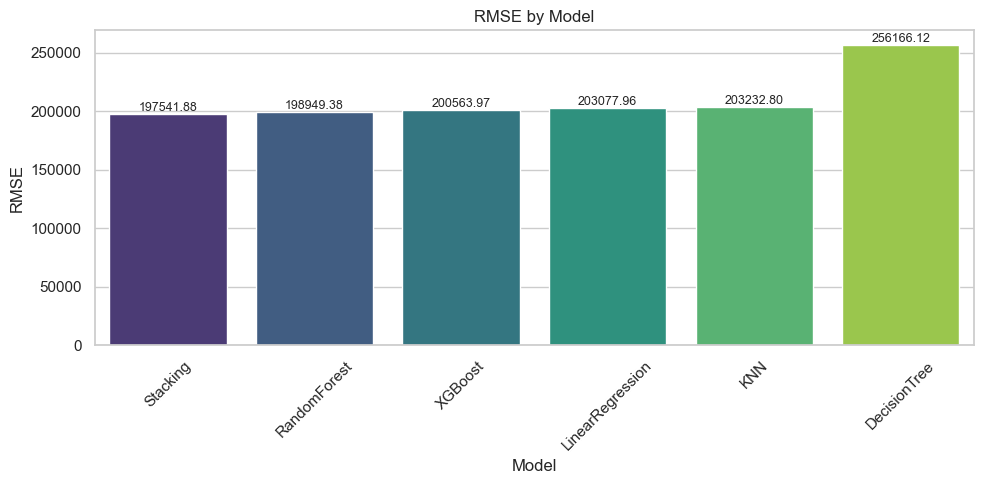

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


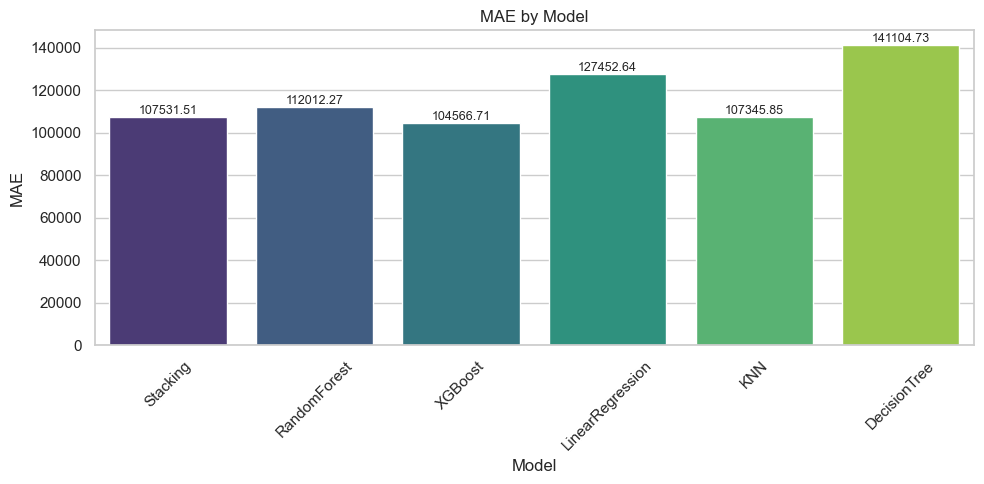

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


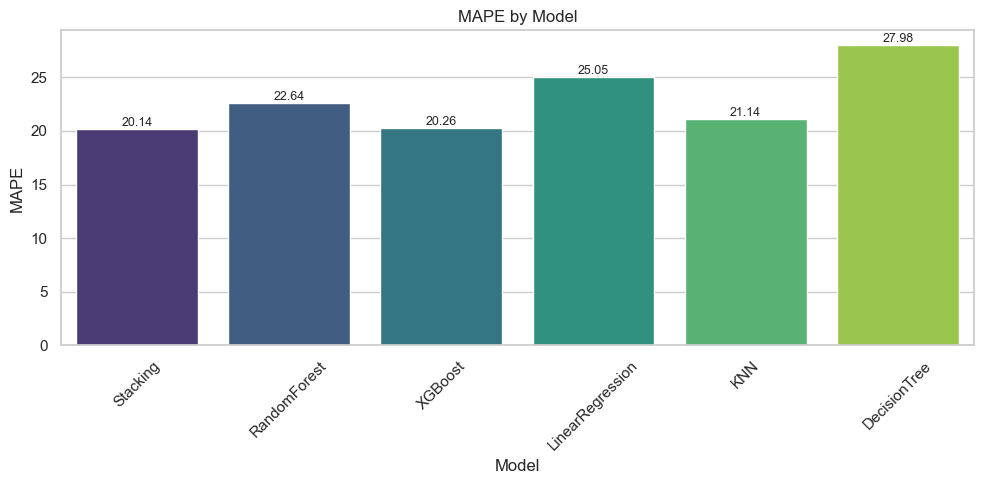

In [62]:
best_estimators['Stacking'] = stack
model_eval_result = evaluate_model(best_estimators, X_val, y_val)
plot_predictions(best_estimators, X_val, y_val)
visualize_results(model_eval_result)


## 4. Model Testing and final thoughts

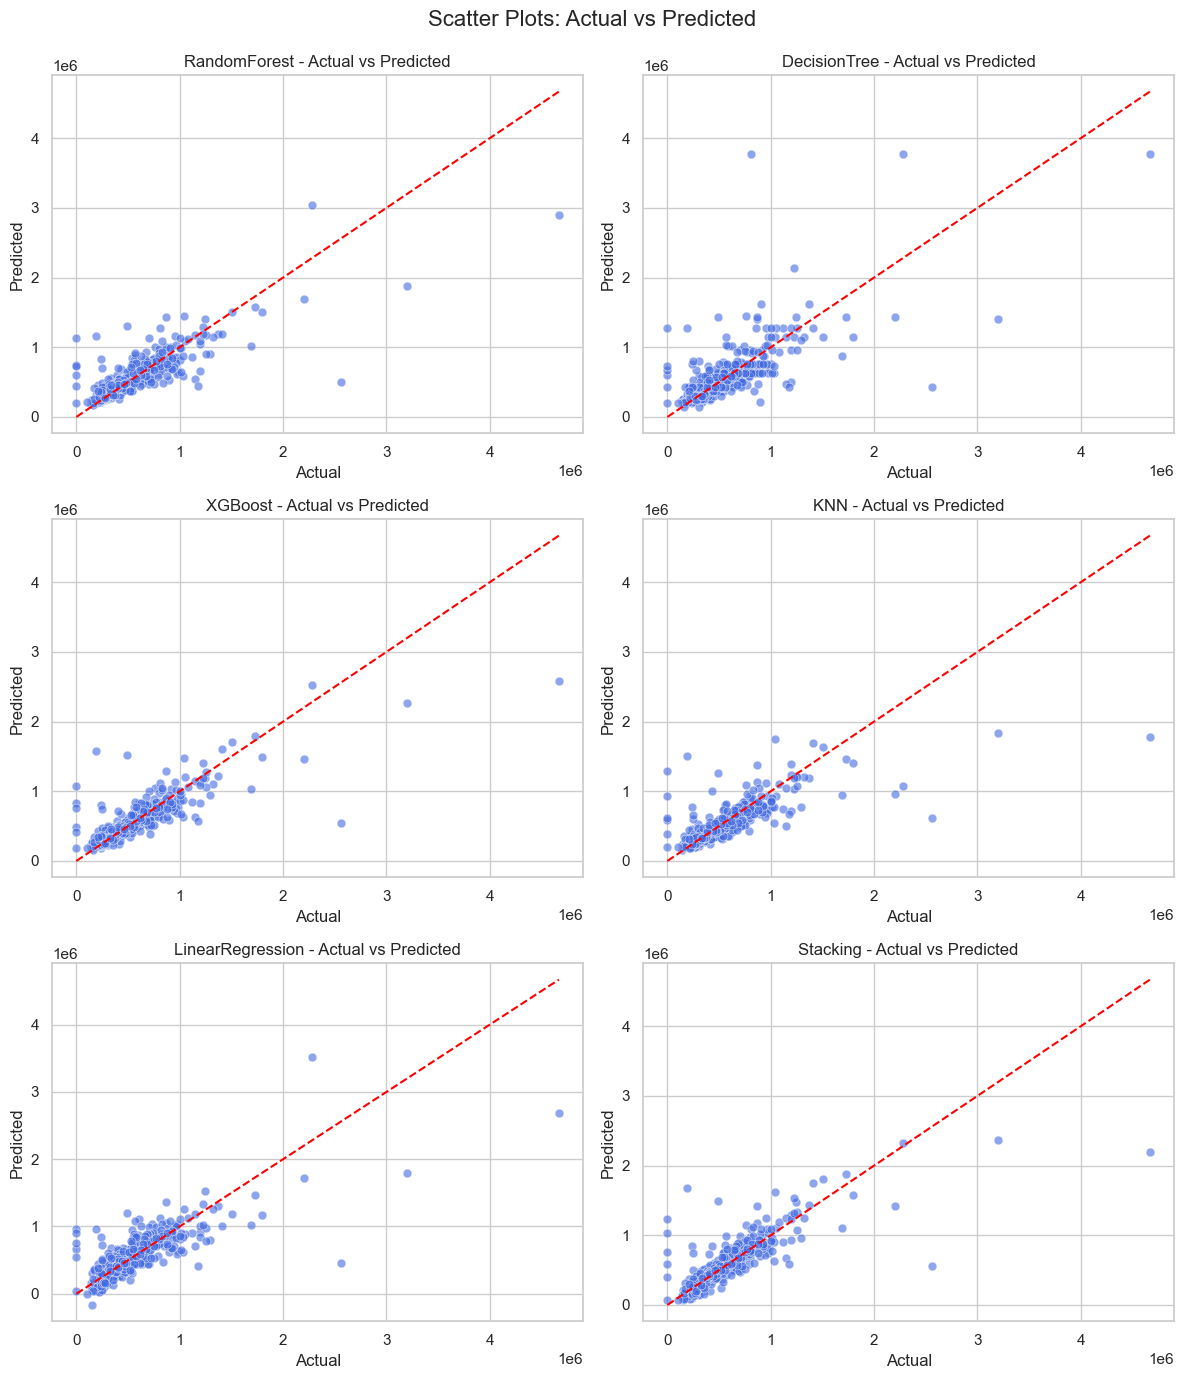

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


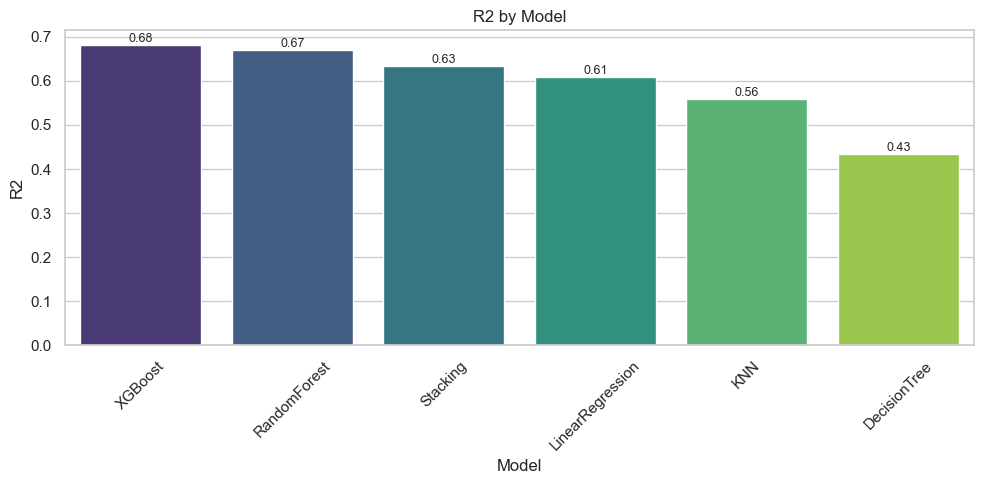

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


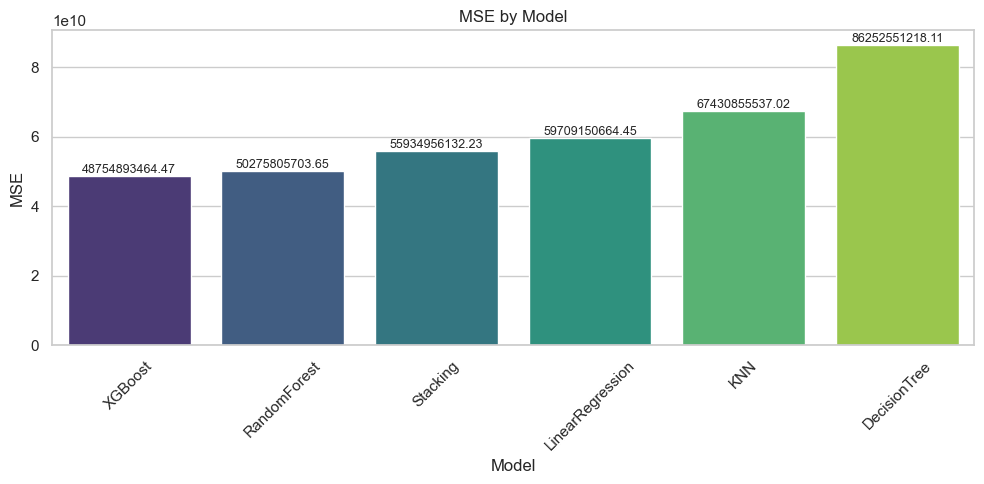

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


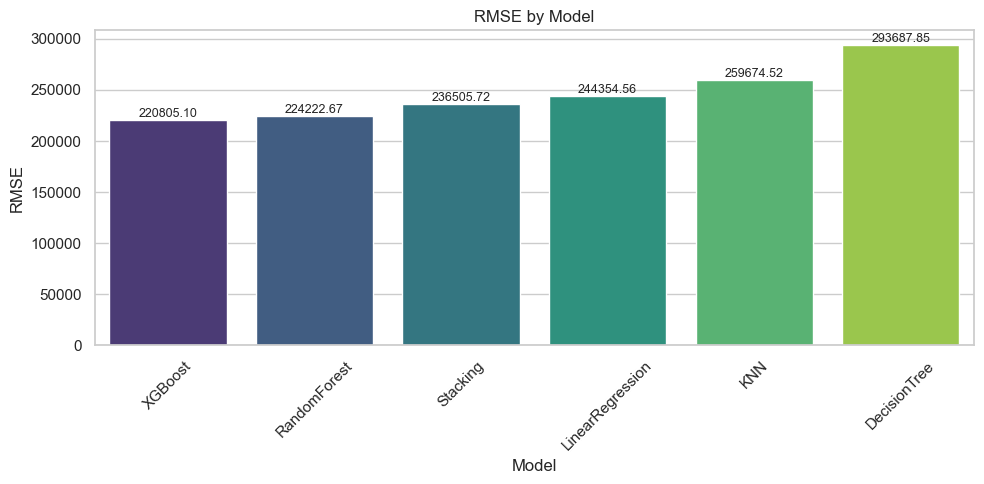

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


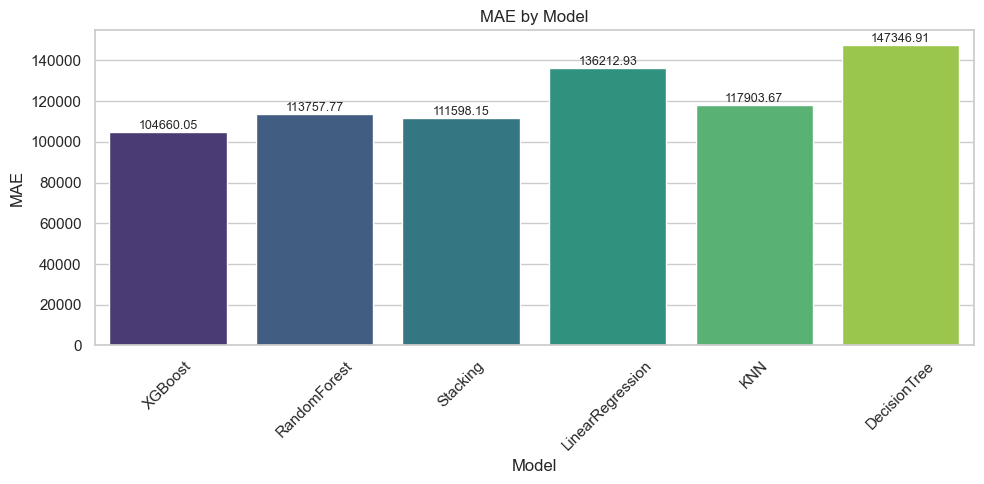

C:\Users\Mile.Stanislavov\AppData\Local\Temp\ipykernel_23652\825927405.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


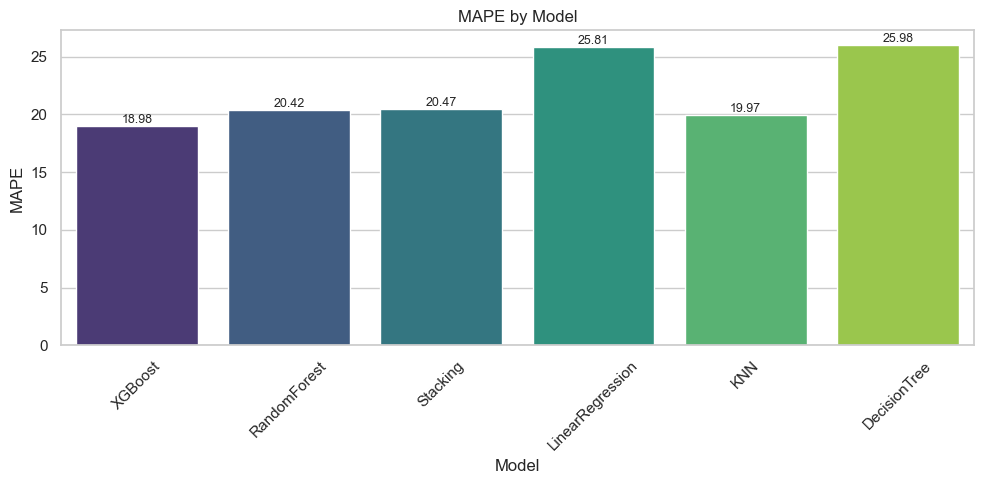

In [64]:
# Now we test the model with the test split
model_eval_result = evaluate_model(best_estimators, X_test, y_test)
plot_predictions(best_estimators, X_test, y_test)
visualize_results(model_eval_result)

#### After all our trials and refinements, one model stood above the rest—XGBoost will power our final release, bringing accuracy, speed, and reliability for most predictions.

### Exporting the model

In [68]:
import os
import joblib

model = best_estimators['XGBoost']

model_dir = '../models'
model_path = os.path.join(model_dir, 'xgboost.joblib')

os.makedirs(model_dir, exist_ok=True)

if not os.listdir(model_dir):
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}.")
else:
    print(f"Directory '{model_dir}' is not empty; skipping save.")

loaded_model = joblib.load(model_path)
assert loaded_model is not None
print("Model loaded successfully.")

Directory '../models' is not empty; skipping save.
Model loaded successfully.
